## Loading the saved pickle file and sparse matrix

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")

In [ ]:
from scipy import sparse
#X_tr = sparse.load_npz("X_tr.npz")
Q_vec_train=sparse.load_npz("XTrain.npz")
Q_vec_test=sparse.load_npz("XTest.npz")

In [30]:
Q_vec_test.shape

(133415, 10019)

In [5]:
import pickle
pickle_in=open("ytrain_quora.pkl","rb")
yTrain=pickle.load(pickle_in)
pickle_in=open("ytest_quora.pkl","rb")
yTest=pickle.load(pickle_in)

In [12]:
import numpy as np
np.unique(yTrain, return_counts=True)

(array([0, 1], dtype=int64), array([170866, 100006], dtype=int64))

Positive classes contribute to only 36%

## Performance metrics

Since we need probabilities of a question being duplicate or not, we use Log loss as a primary performance metrics.
However, to get more interpretability we have to use confusion matrix, precison and recall matrix. We use precision and recall matrix here because here both the class True negative and True positive is important.
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

Function to create a all the matrix we need

In [23]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    Recall =(((C.T)/(C.sum(axis=1))).T)
    
    Precision =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(Precision, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(Recall, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Building a random benchmark model

For every xi generate yi randomly.This is a dumb/random model. 
Log loss that we get on a random model is a benchmark

Log loss on Test Data using Random Model 0.883590895597777


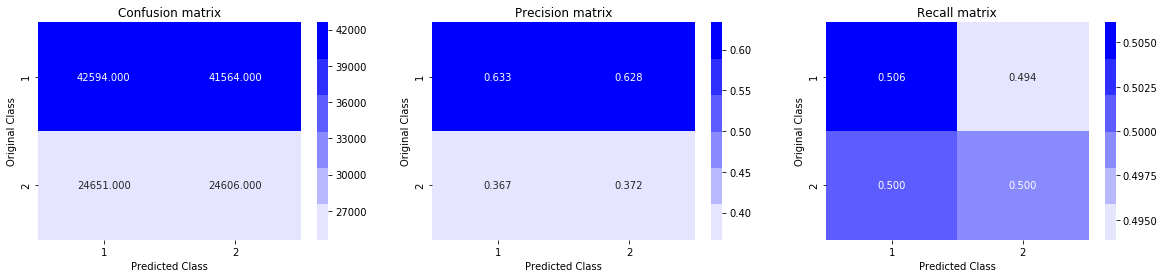

In [24]:
test_len = len(yTest)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(yTest, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(yTest, predicted_y)

### SGD Classifier 

First find the best regularization parameter using simple cross validation. Then using caliberated classifier output of each class can be obtained.
Train the model on the best hyperparameter.

For values of alpha =  1e-05 The log loss is: 0.49673047832835765
For values of alpha =  0.0001 The log loss is: 0.49259820739800797
For values of alpha =  0.001 The log loss is: 0.5008924234002557
For values of alpha =  0.01 The log loss is: 0.4883407334687164
For values of alpha =  0.1 The log loss is: 0.4929894264517411
For values of alpha =  1 The log loss is: 0.5126744167368789
For values of alpha =  10 The log loss is: 0.544956195158641


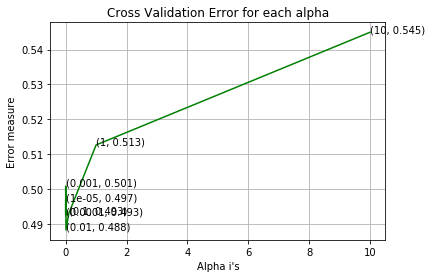

For values of best alpha =  0.01 The train log loss is: 0.49028192806281196
For values of best alpha =  0.01 The test log loss is: 0.4883407334687164
Total number of data points : 133415


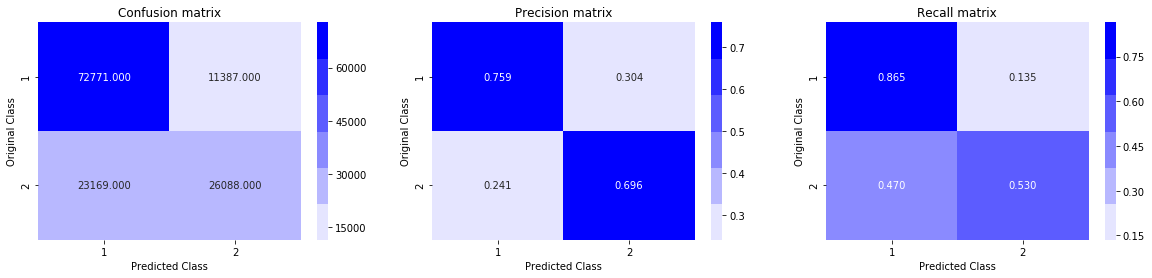

In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(Q_vec_train, yTrain)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") #log loss requires caliberated classifier
    sig_clf.fit(Q_vec_train, yTrain)
    predict_y = sig_clf.predict_proba(Q_vec_test)
    log_error_array.append(log_loss(yTest, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(yTest, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(Q_vec_train, yTrain)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(Q_vec_train, yTrain)

predict_y = sig_clf.predict_proba(Q_vec_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(yTrain, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(Q_vec_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(yTest, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(yTest, predicted_y)

### Linear SVM Classifier 

For values of alpha =  1e-05 The log loss is: 0.4904403971377281
For values of alpha =  0.0001 The log loss is: 0.4708924078492594
For values of alpha =  0.001 The log loss is: 0.49823508212173395
For values of alpha =  0.01 The log loss is: 0.5044594400393801
For values of alpha =  0.1 The log loss is: 0.520542562700002
For values of alpha =  1 The log loss is: 0.6408602374730451
For values of alpha =  10 The log loss is: 0.6290163432686683


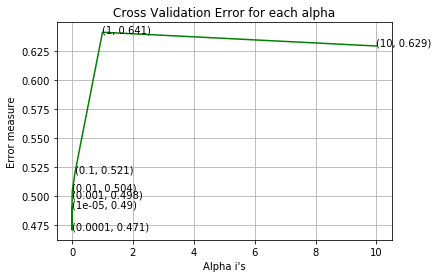

For values of best alpha =  0.0001 The train log loss is: 0.4723768516127766
For values of best alpha =  0.0001 The test log loss is: 0.4708924078492594
Total number of data points : 133415


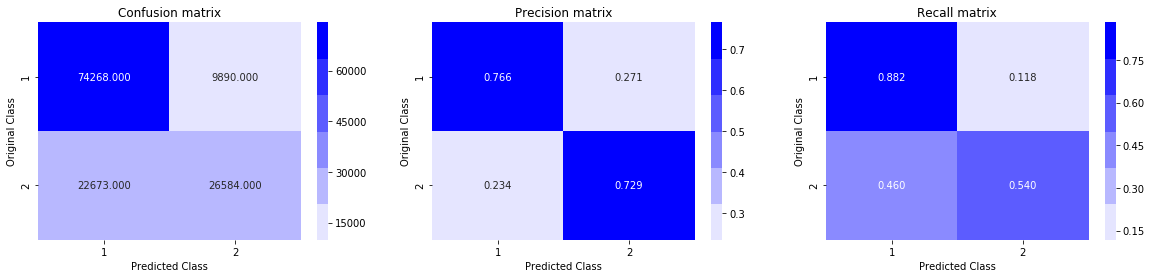

In [32]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(Q_vec_train, yTrain)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Q_vec_train, yTrain)
    predict_y = sig_clf.predict_proba(Q_vec_test)
    log_error_array.append(log_loss(yTest, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(yTest, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(Q_vec_train, yTrain)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(Q_vec_train, yTrain)

predict_y = sig_clf.predict_proba(Q_vec_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(yTrain, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(Q_vec_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(yTest, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(yTest, predicted_y)

### XG Boost Model

In [35]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(Q_vec_train, label=yTrain)
d_test = xgb.DMatrix(Q_vec_test, label=yTest)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

xgdmat = xgb.DMatrix(Q_vec_train,yTrain)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(yTest, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68453	valid-logloss:0.68447
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.61319	valid-logloss:0.61286
[20]	train-logloss:0.56219	valid-logloss:0.56181
[30]	train-logloss:0.52425	valid-logloss:0.52389
[40]	train-logloss:0.49517	valid-logloss:0.49476
[50]	train-logloss:0.47304	valid-logloss:0.47262
[60]	train-logloss:0.45532	valid-logloss:0.45496
[70]	train-logloss:0.44121	valid-logloss:0.44084
[80]	train-logloss:0.42978	valid-logloss:0.42954
[90]	train-logloss:0.42024	valid-logloss:0.42006
[100]	train-logloss:0.41287	valid-logloss:0.41269
[110]	train-logloss:0.40672	valid-logloss:0.40657
[120]	train-logloss:0.40176	valid-logloss:0.40160
[130]	train-logloss:0.39737	valid-logloss:0.39722
[140]	train-logloss:0.39371	valid-logloss:0.39358
[150]	train-logloss:0.39064	valid-logloss:0.39053
[160]	train-logloss:0.38782	valid-logloss:0.38774
[170]	trai

This is so far the best model with the least log loss

## Further enhancements that can be done

Now I have considered only three models and I have not done cross validation on XGBoost parameters. 
We can do cross validation on XGBoost parameters to see if log loss is reduced even further.
Also I have considered only TFIDF word vectors as features with n-gram 1-3.
We can see how log loss will reduce if Word-2-Vec features are used.